In [1]:
from data_loader import data_reader, colnames, colnames_bid
#from inverse_cdf import inverse
from matplotlib import pyplot as plt
import math
import pandas as pd
import numpy as np

In [2]:
imp_19 = data_reader('data\\imp.20131019.txt', colnames, 
                verbose=False, fuck_parsing=True)
bid_19 = data_reader('data\\bid.20131019.txt', colnames_bid, verbose=False, fuck_parsing=True)
clk_19 = data_reader('data\\clk.20131019.txt', colnames, verbose=False, fuck_parsing=True)
conv_19 = data_reader('data\\conv.20131019.txt', colnames, verbose=False, fuck_parsing=True)


imp_20 = data_reader('data\\imp.20131020.txt', colnames, 
                verbose=False, fuck_parsing=True)
bid_20 = data_reader('data\\bid.20131020.txt', colnames_bid, verbose=False, fuck_parsing=True)
clk_20 = data_reader('data\\clk.20131020.txt', colnames, verbose=False, fuck_parsing=True)
conv_20 = data_reader('data\\conv.20131020.txt', colnames, verbose=False, fuck_parsing=True)

In [3]:
imp = imp_19.append(imp_20, ignore_index=True)
bid = bid_19.append(bid_20, ignore_index=True)
clk = clk_19.append(clk_20, ignore_index=True)
conv = conv_19.append(conv_20, ignore_index=True)

In [4]:
imp.shape[0] == imp_19.shape[0] + imp_20.shape[0] and \
bid.shape[0] == bid_19.shape[0] + bid_20.shape[0] and \
clk.shape[0] == clk_19.shape[0] + clk_20.shape[0] and \
conv.shape[0] == conv_19.shape[0] + conv_20.shape[0]

True

In [5]:
bid_rel = bid[['bid_id', 'timestamp']]
imp_rel = imp[['bid_id', 'paying_price']]
# clk_rel = clk[['bid_id', 'paying_price']]
# conv_rel = conv[['bid_id', 'paying_price']]
bids = bid_rel.merge(imp_rel,how='left', on='bid_id').sort_values('timestamp')
bids['not_bought'] = [math.isnan(price) for price in bids.paying_price]
# bids.paying_price = bids.paying_price.fillna(0)
bids = bids.dropna()

In [15]:
def split_explore_exploit(bids, share_exploration):
    N = bids.shape[0]
    this_many = int(share_exploration * N)
    bids_explore = bids.iloc[:this_many, :]
    bids_exploit = bids.iloc[this_many:, :]
    return bids_explore, bids_exploit, N

share_exploration = 0.01
bids_explore, bids_exploit, N = split_explore_exploit(bids, share_exploration)

G = 1e5
B = 6e6
target_price =  B / G
target_winrate = G / N




print(bids_explore.shape)
print(target_price)
print(target_winrate)

(4424, 4)
60.0
0.22602547759183414


In [29]:
def explore(bids_explore, target_price, N, rounds=5, plot_win_fct=False):
    bid_price = target_price
    N_expl = bids_explore.shape[0]
    step = int(N_expl / rounds)
    start = 0
    stop = step
    for round in range(rounds):
        won = 0
        cost = 0
        winning_prices = [np.nan] * step
        index=0
        for _, bid in bids_explore \
                            .iloc[start:stop, :] \
                            .iterrows():
            if bid_price > bid.paying_price:
                won += 1
                cost += bid.paying_price
                winning_prices[index] = bid.paying_price
            index += 1
        if plot_win_fct:
            sorted_data = np.sort(winning_prices)
            yvals = np.arange(step) / float(step-1) #len(winning_prices) = step
            plt.plot(sorted_data, yvals)
            plt.show()
        winrate = won / step
        price = cost / won
        exp_views = N * winrate
#         exp_price = cost / step #preco?
        
        if  (exp_views < G) or (price < target_price):
            bid_price = bid_price * 2
            print('Doubling')
            print("winrate: %.2f" % winrate)
            print("price: %.2f" % price)
            
        else:
            print('breaking in round %s' % (round + 1))
            print('winrate: %.2f' % winrate)
            print('E(views): %.2f > target_views %.2f' % \
                  (exp_views, G))
            print('E(price): %.2f > target_price %.2f' % \
                  (price, target_price))
            break
        start += step
        stop += step
        
    winning_prices.sort()
    yvalues = np.arange(len(winning_prices)) / float(len(winning_prices)-1)

    cdf = pd.DataFrame({'price' : winning_prices, 
                        'value' : yvalues})
    return cdf


def exploit(cdf, target_winrate, target_price, N, G):
    
    idx_bG = (np.abs(cdf.value - target_winrate)).argmin()
    b_G = cdf.price[idx_bG]
    
    expected_F = np.array([])
    
    for length in np.arange(1, cdf.shape[0]):
        subset = cdf.price[:length]
        probability = 1 / subset.size
        expected_F = np.append(expected_F, sum(subset) * probability)
        
    idx_bB = (np.abs(expected_F - target_price)).argmin()
    b_B = cdf.price[idx_bB]
    probability_b_B = G / (N * cdf.value[idx_bB])
    print(np.abs(expected_F - target_price))
    bid_price = b_B if np.random.uniform(0, 1, 1) < probability_b_B and b_G <= b_B else b_G
    
    return bid_price, b_G, b_B, probability_b_B, idx_bG

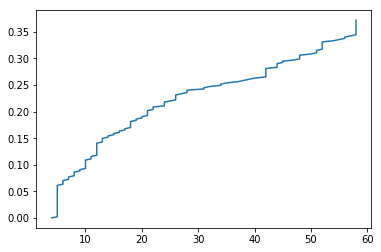

0.3733031674208145
25.242424242424242
doubling


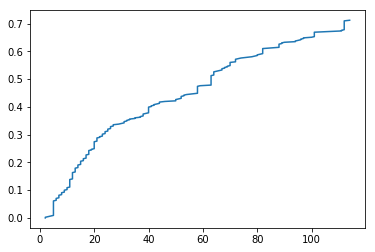

0.7126696832579186
42.977777777777774
doubling


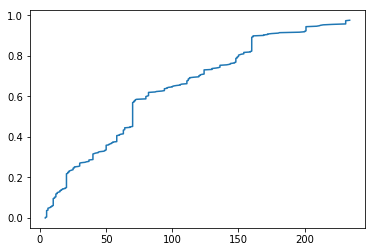

breaking in round 3
winrate: 0.98
E(views): 431417.35 > target_views 100000.00
E(price): 81.15 > target_price 60.00


11

In [31]:
abc = explore(bids_explore, target_price, N, rounds=10, plot_win_fct=True)
sum(abc.price.isnull())
# exploit(abc, target_winrate, target_price, N, G)

In [32]:
for _ in range(10):
    s = exploit(abc, target_winrate, target_price, N, G)
    print(s)

[56.         55.5        55.33333333 55.         54.8        54.33333333
 53.71428571 53.25       52.77777778 52.3        51.27272727 50.33333333
 49.53846154 48.85714286 48.26666667 47.75       47.29411765 46.88888889
 46.52631579 46.2        45.9047619  45.63636364 45.39130435 45.125
 44.84       44.46153846 44.11111111 43.75       43.27586207 42.83333333
 42.29032258 41.75       41.18181818 40.55882353 39.97142857 39.41666667
 38.89189189 38.39473684 37.92307692 37.25       36.58536585 35.95238095
 35.34883721 34.68181818 33.95555556 33.26086957 32.59574468 31.85416667
 31.         30.18       29.39215686 28.63461538 27.90566038 27.2037037
 26.52727273 25.875      25.24561404 24.63793103 24.05084746 23.48333333
 22.93442623 22.40322581 21.84126984 21.1875     20.55384615 19.90909091
 19.20895522 18.39705882 17.55072464 16.64285714 15.69014085 14.76388889
 13.84931507 12.94594595 11.97333333 11.          9.94805195  8.92307692
  7.84810127  6.65        5.48148148  4.34146341  3.18072

[56.         55.5        55.33333333 55.         54.8        54.33333333
 53.71428571 53.25       52.77777778 52.3        51.27272727 50.33333333
 49.53846154 48.85714286 48.26666667 47.75       47.29411765 46.88888889
 46.52631579 46.2        45.9047619  45.63636364 45.39130435 45.125
 44.84       44.46153846 44.11111111 43.75       43.27586207 42.83333333
 42.29032258 41.75       41.18181818 40.55882353 39.97142857 39.41666667
 38.89189189 38.39473684 37.92307692 37.25       36.58536585 35.95238095
 35.34883721 34.68181818 33.95555556 33.26086957 32.59574468 31.85416667
 31.         30.18       29.39215686 28.63461538 27.90566038 27.2037037
 26.52727273 25.875      25.24561404 24.63793103 24.05084746 23.48333333
 22.93442623 22.40322581 21.84126984 21.1875     20.55384615 19.90909091
 19.20895522 18.39705882 17.55072464 16.64285714 15.69014085 14.76388889
 13.84931507 12.94594595 11.97333333 11.          9.94805195  8.92307692
  7.84810127  6.65        5.48148148  4.34146341  3.18072

[56.         55.5        55.33333333 55.         54.8        54.33333333
 53.71428571 53.25       52.77777778 52.3        51.27272727 50.33333333
 49.53846154 48.85714286 48.26666667 47.75       47.29411765 46.88888889
 46.52631579 46.2        45.9047619  45.63636364 45.39130435 45.125
 44.84       44.46153846 44.11111111 43.75       43.27586207 42.83333333
 42.29032258 41.75       41.18181818 40.55882353 39.97142857 39.41666667
 38.89189189 38.39473684 37.92307692 37.25       36.58536585 35.95238095
 35.34883721 34.68181818 33.95555556 33.26086957 32.59574468 31.85416667
 31.         30.18       29.39215686 28.63461538 27.90566038 27.2037037
 26.52727273 25.875      25.24561404 24.63793103 24.05084746 23.48333333
 22.93442623 22.40322581 21.84126984 21.1875     20.55384615 19.90909091
 19.20895522 18.39705882 17.55072464 16.64285714 15.69014085 14.76388889
 13.84931507 12.94594595 11.97333333 11.          9.94805195  8.92307692
  7.84810127  6.65        5.48148148  4.34146341  3.18072

[56.         55.5        55.33333333 55.         54.8        54.33333333
 53.71428571 53.25       52.77777778 52.3        51.27272727 50.33333333
 49.53846154 48.85714286 48.26666667 47.75       47.29411765 46.88888889
 46.52631579 46.2        45.9047619  45.63636364 45.39130435 45.125
 44.84       44.46153846 44.11111111 43.75       43.27586207 42.83333333
 42.29032258 41.75       41.18181818 40.55882353 39.97142857 39.41666667
 38.89189189 38.39473684 37.92307692 37.25       36.58536585 35.95238095
 35.34883721 34.68181818 33.95555556 33.26086957 32.59574468 31.85416667
 31.         30.18       29.39215686 28.63461538 27.90566038 27.2037037
 26.52727273 25.875      25.24561404 24.63793103 24.05084746 23.48333333
 22.93442623 22.40322581 21.84126984 21.1875     20.55384615 19.90909091
 19.20895522 18.39705882 17.55072464 16.64285714 15.69014085 14.76388889
 13.84931507 12.94594595 11.97333333 11.          9.94805195  8.92307692
  7.84810127  6.65        5.48148148  4.34146341  3.18072

[56.         55.5        55.33333333 55.         54.8        54.33333333
 53.71428571 53.25       52.77777778 52.3        51.27272727 50.33333333
 49.53846154 48.85714286 48.26666667 47.75       47.29411765 46.88888889
 46.52631579 46.2        45.9047619  45.63636364 45.39130435 45.125
 44.84       44.46153846 44.11111111 43.75       43.27586207 42.83333333
 42.29032258 41.75       41.18181818 40.55882353 39.97142857 39.41666667
 38.89189189 38.39473684 37.92307692 37.25       36.58536585 35.95238095
 35.34883721 34.68181818 33.95555556 33.26086957 32.59574468 31.85416667
 31.         30.18       29.39215686 28.63461538 27.90566038 27.2037037
 26.52727273 25.875      25.24561404 24.63793103 24.05084746 23.48333333
 22.93442623 22.40322581 21.84126984 21.1875     20.55384615 19.90909091
 19.20895522 18.39705882 17.55072464 16.64285714 15.69014085 14.76388889
 13.84931507 12.94594595 11.97333333 11.          9.94805195  8.92307692
  7.84810127  6.65        5.48148148  4.34146341  3.18072

In [23]:
abc

,price,value
0,4.0,0.000000
1,5.0,0.002268
2,5.0,0.004535
3,6.0,0.006803
4,6.0,0.009070
5,8.0,0.011338
6,10.0,0.013605
7,10.0,0.015873
8,11.0,0.018141
9,12.0,0.020408


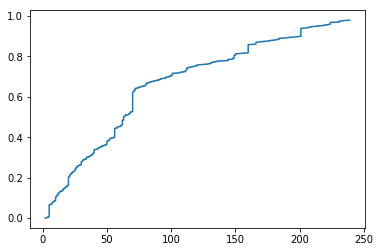

In [62]:
sorted_data = np.sort(abc.price)
yvals=np.arange(len(abc))/float(len(abc)-1)
plt.plot(sorted_data,yvals)
plt.show()

In [63]:
float(len(abc)-1)

2211.0

In [64]:
counts = pd.Series(sorted_data).value_counts(normalize=True, sort=False, dropna=False)
sorted_data=pd.DataFrame(sorted_data)

In [65]:
sorted_data.columns = ['values']

In [66]:

counts=pd.DataFrame(counts)
for_b_B = sorted_data.merge(counts, left_on='values', right_index=True)

In [67]:
for_b_B.columns = ['vals', 'freq']

In [78]:
sum(abc.price.isnull())

45

In [70]:
d = for_b_B.groupby('vals').mean()

for i in np.arange(1, d.shape[0]):
    cumsum = sum(d.iloc[:i, :].index * d.iloc[:i, :].freq)
#     print(cumsum)
    if cumsum > target_price:
        print(cumsum)
        print(d.iloc[i, :])
        break

66.83634719710672
freq    0.000904
Name: 202.0, dtype: float64
